In [1]:
import zntrack
import matplotlib.pyplot as plt
import numpy as np

In [2]:
volume_scans = [zntrack.from_rev("evaluation_BoxScale")]
volume_scans.extend([zntrack.from_rev(f"evaluation_BoxScale_{x}") for x in range(1, 14)])

dft = zntrack.from_rev("volume_scan_CP2KSinglePoint_1")

2023-08-11 08:19:18,209 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [4]:
dft_energies = np.array([x.get_potential_energy() for x in dft.atoms])

/tmp/ipykernel_709619/203502603.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


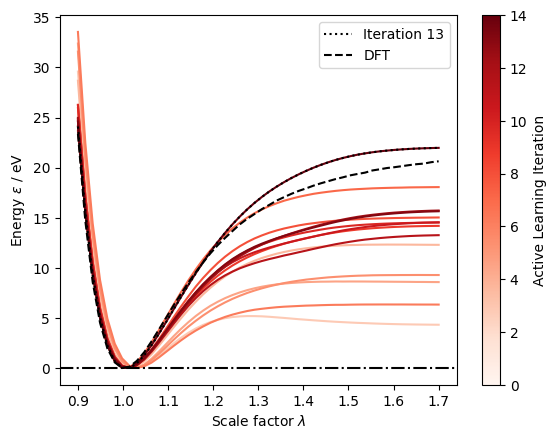

In [11]:
fig, ax = plt.subplots()


colors = plt.cm.Reds(np.linspace(0.2, 1, len(volume_scans)))

for idx, vs in enumerate(volume_scans):
    energies = np.array([x.get_potential_energy() for x in vs.atoms])
    energies -= min(energies)

    ax.plot(np.linspace(volume_scans[0].start, volume_scans[0].stop, volume_scans[0].num), energies, color=colors[idx])


ax.plot(np.linspace(volume_scans[0].start, volume_scans[0].stop, volume_scans[0].num), energies, color="black", ls=":", label=f"Iteration {len(volume_scans) - 1}")

# ax.set_xlim(0.90, 1.50)

ax.plot(np.linspace(0.9, 1.7, len(energies)), dft_energies - min(dft_energies), label="DFT", color="black", ls="--")
# add a color bar to the side
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=len(volume_scans)))
cbar = fig.colorbar(sm)
cbar.set_label("Active Learning Iteration")

ax.set_ylabel(r"Energy $\epsilon $ / eV")
ax.set_xlabel(r"Scale factor $\lambda $")

plt.axhline(y=0.0, color='black', linestyle='-.')

ax.legend()
# fig.savefig("energy_vs_scale_factor.png", bbox_inches ="tight", dpi=300)

In [4]:
metrics = [zntrack.from_rev("evaluation_PredictionMetrics")]
metrics.extend([zntrack.from_rev(f"evaluation_PredictionMetrics_{x}") for x in range(1, 14)])

In [5]:
n_train_data = [len(x.data.model.models[0].data) for x in metrics]

In [6]:
n_train_data

[42, 52, 62, 72, 82, 92, 122, 222, 245, 256, 267, 289, 311, 493]

Text(0.5, 0, '# training configurations')

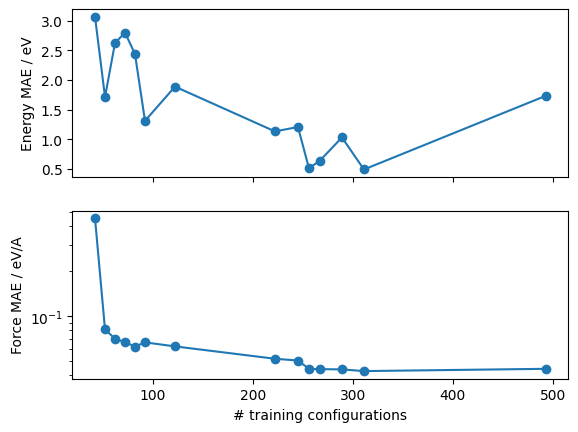

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True)
data = [x.energy["mae"] for x in metrics]


ax[0].plot(n_train_data, data, "-o")
ax[0].set_ylabel("Energy MAE / eV")

data = [x.forces["mae"] for x in metrics]
ax[1].plot(n_train_data, data, "-o")
ax[1].set_yscale("log")
ax[1].set_ylabel("Force MAE / eV/A")
ax[1].set_xlabel("# training configurations")

# Selection

In [6]:
import zntrack
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import ipsuite as ips

In [2]:
md = zntrack.from_rev("AL2_5_ASEMD")

2023-08-13 18:06:36,439 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [3]:
len(md.atoms)

25000

In [23]:
u_energy = ips.configuration_selection.UniformEnergeticSelection(md.atoms, n_configurations=10)
u_energy.run()
u_energy.selected_configurations

In [59]:
time = ips.configuration_selection.UniformTemporalSelection(md.atoms, n_configurations=10)
time.run()
time.selected_configurations

2023-08-13 18:18:53,489 (DEBUG): Selecting from 25000 configurations.


[0, 2778, 5555, 8333, 11111, 13888, 16666, 19444, 22221, 24999]

In [77]:
random = ips.configuration_selection.RandomSelection(md.atoms, n_configurations=10)
random.run()
random.selected_configurations

2023-08-13 18:22:39,918 (DEBUG): Selecting from 25000 configurations.


[2633, 2811, 5262, 9937, 14051, 17442, 19404, 19848, 22512, 22764]

In [7]:
energy = np.array([x.get_potential_energy() for x in md.atoms])

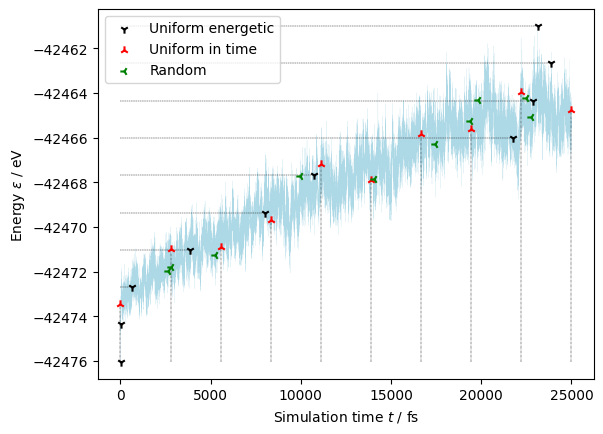

In [87]:
fig, ax = plt.subplots()
ax.plot(energy, lw=0.1, color="lightblue")

ax.scatter(u_energy.selected_configurations, energy[u_energy.selected_configurations], color="black", marker="1", label="Uniform energetic", zorder=10)
for idx in u_energy.selected_configurations:
    ax.hlines(energy[idx], xmin=0, xmax=idx, ls="--", lw=0.3, color="black")

ax.scatter(time.selected_configurations, energy[time.selected_configurations], color="red", marker="2", label="Uniform in time", zorder=10)
for idx in time.selected_configurations:
    ax.vlines(idx, ymin=min(energy), ymax=energy[idx], ls="-.", lw=0.3, color="black")    

ax.scatter(random.selected_configurations, energy[random.selected_configurations], color="green", marker="3", label="Random", zorder=10)
ax.set_xlabel(r"Simulation time $t$ / fs")
ax.set_ylabel(r"Energy $\epsilon$ / eV")
ax.legend()
fig.savefig("selection_methods.png", bbox_inches ="tight", dpi=300)